# Customer Churn Prediction with various Machine Learning Algorithms
# (IBM Telco Dataset)

## Import packages, defining functions & configurations

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import math
import imblearn
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif, SelectFpr

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score
from sklearn import tree

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,16]
plt.rcParams['font.size'] =12

In [ ]:
# Print stacked plot

def stacked_bar(cols, super_title):

    rows = math.ceil(len(cols)/2)

    fig = plt.figure(figsize=(35, 6 * rows))
    fig.suptitle(super_title, fontsize=14,  y=.95)

    for index, column in enumerate(cols, 1):

        ax = fig.add_subplot(rows, 4, index)

        # % churn & non-churn
        i = pd.crosstab(df[column], df['Churn Label']).apply(lambda x: x/x.sum()*100, axis=1)

        i.plot(kind='bar', ax=ax, stacked=True, rot=0, color=['#FFF0CA','#C9E45F'])

        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5), title='Churn')
        ax.set_title('Proportion of observations by ' + column, fontsize=14, loc='left')
        ax.tick_params(rotation='auto')

        sname = ('top', 'right', 'bottom', 'left')
        for spine_name in sname:
            ax.spines[spine_name].set_visible(False)

In [ ]:
# Print histogram

def plot_histogram(cols, super_title):

  rows = math.ceil(len(cols)/2)

  fig = plt.figure(figsize=(30, 6 * rows))
  fig.suptitle(super_title, fontsize=22,  y=.95)

  for ind, column in enumerate(cols, 1):

    ax = fig.add_subplot(rows, 4, ind)

    # histogram for each class
    df[df['Churn Label']=='No'][column].plot(kind='hist', ax=ax, density=True, alpha=0.5, color='#F8CEE4', label='No')
    df[df['Churn Label']=='Yes'][column].plot(kind='hist', ax=ax, density=True, alpha=0.5, color='#C9E45F', label='Yes')

    ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), title='Churn')

    ax.set_title('Distribution of ' + column + ' by churn', fontsize=16, loc='left')
    ax.tick_params(rotation='auto')

    snames = ('top', 'right', 'bottom', 'left')
    for sname in snames:
      ax.spines[sname].set_visible(False)

## Reading the dataset & data cleaning
* Remove empty values (11 rows)
* Removing insignificant columns

In [ ]:
df = pd.read_excel("/input/Telco_customer_churn.xlsx")

In [ ]:
# df.columns
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [ ]:
df = df.drop_duplicates()

In [ ]:
df = df.drop(['Country','State','Count'], axis = 1)

In [ ]:
df = df.drop(['Churn Reason'], axis = 1)
df.drop(columns='CustomerID', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   City               7043 non-null   object 
 1   Zip Code           7043 non-null   int64  
 2   Lat Long           7043 non-null   object 
 3   Latitude           7043 non-null   float64
 4   Longitude          7043 non-null   float64
 5   Gender             7043 non-null   object 
 6   Senior Citizen     7043 non-null   object 
 7   Partner            7043 non-null   object 
 8   Dependents         7043 non-null   object 
 9   Tenure Months      7043 non-null   int64  
 10  Phone Service      7043 non-null   object 
 11  Multiple Lines     7043 non-null   object 
 12  Internet Service   7043 non-null   object 
 13  Online Security    7043 non-null   object 
 14  Online Backup      7043 non-null   object 
 15  Device Protection  7043 non-null   object 
 16  Tech Support       7043 

In [ ]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df.isna().sum()

City                  0
Zip Code              0
Lat Long              0
Latitude              0
Longitude             0
Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn Label           0
Churn Value           0
Churn Score           0
CLTV                  0
dtype: int64

In [ ]:
df[df['Total Charges'].isnull()]
df.dropna(inplace=True)

In [ ]:
df['Payment Method'] = df['Payment Method'].str.replace(' (automatic)', '', regex=False)
df["Payment Method"].unique()

array(['Mailed check', 'Electronic check', 'Bank transfer', 'Credit card'],
      dtype=object)

## Data Visualization

### Customer distribution

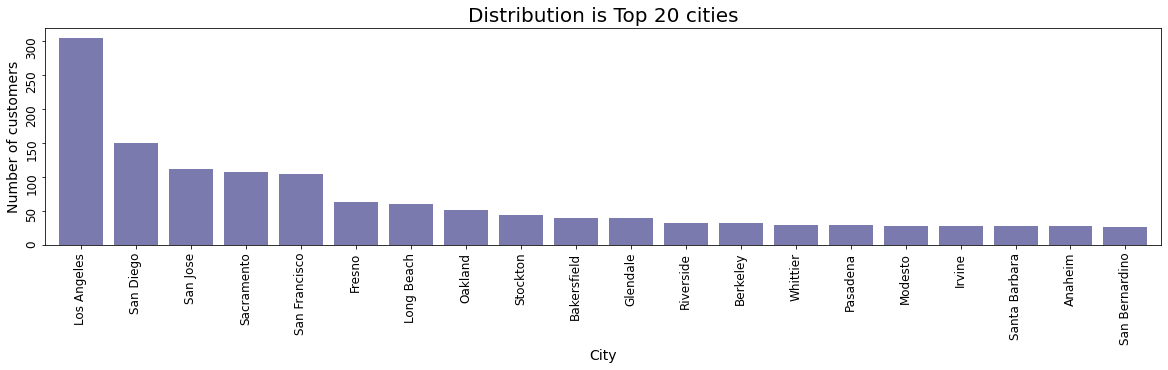

In [ ]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

r = df['City'].value_counts().sort_values(ascending = False)[:20]

r.plot(kind = 'bar', ax = ax, width = 0.8, color = '#7B7AAF')

ax.set_title('Distribution is Top 20 cities', fontsize = 20)
ax.set_xlabel('City', fontsize = 14)
ax.set_ylabel('Number of customers', fontsize = 14)
ax.tick_params(rotation=90)

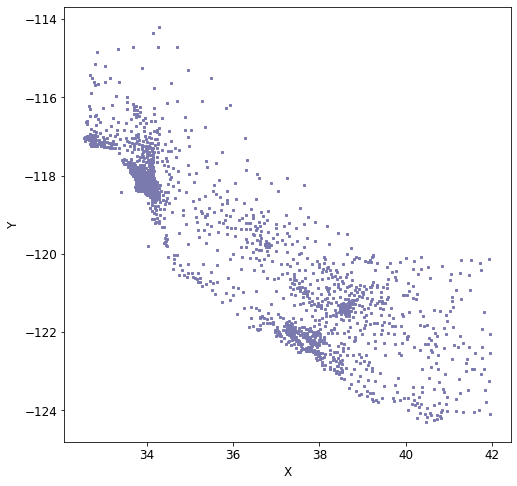

In [ ]:
from numpy.core.fromnumeric import shape
fig = plt.figure(figsize=(8,8))
plt.scatter(df["Latitude"],df["Longitude"], s=3, color = ['#7B7AAF'])
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

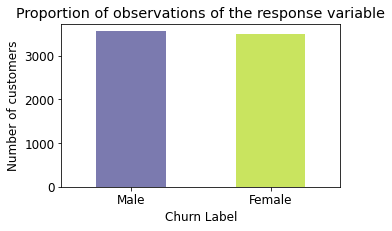

In [ ]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)

r = df['Gender'].value_counts()

r.plot(kind = 'bar', ax = ax, color=['#7B7AAF','#C9E45F'])

# set title and labels
ax.set_title('Proportion of observations of the response variable')
ax.set_xlabel('Churn Label')
ax.set_ylabel('Number of customers')
ax.tick_params(rotation='auto')


### Demographic Information

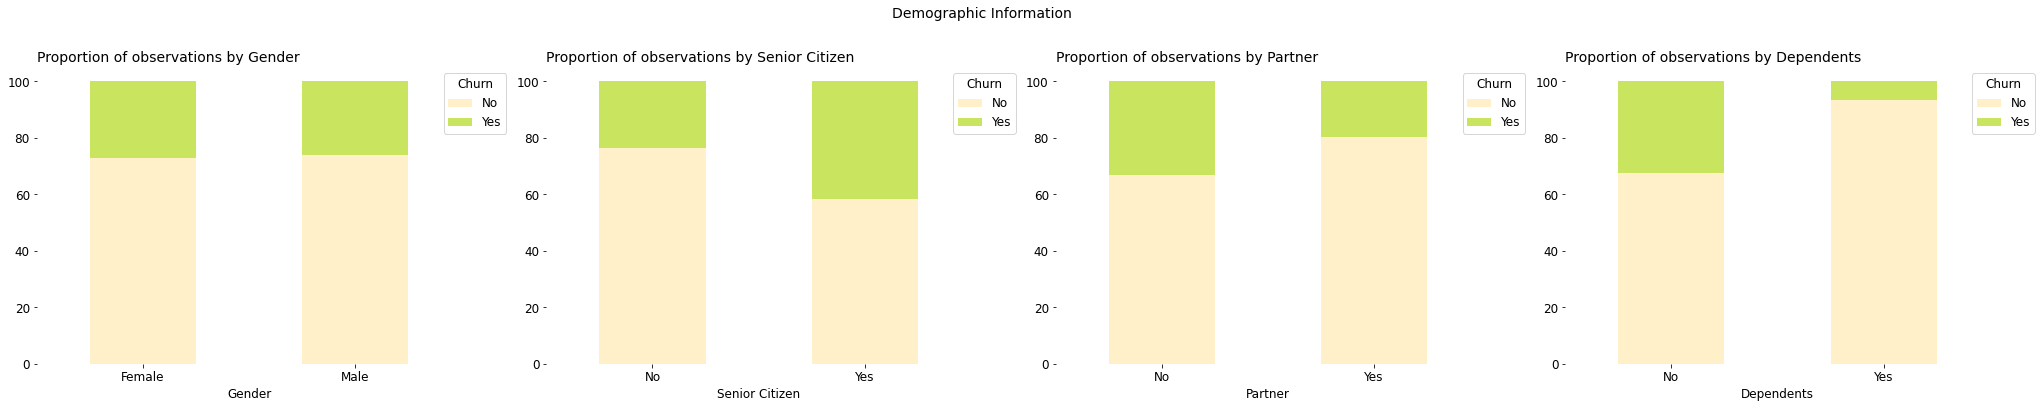

In [ ]:
# demographic column names
demographic_columns = ['Gender', 'Senior Citizen', 'Partner', 'Dependents']

# stacked plot of demographic columns
stacked_bar(demographic_columns, 'Demographic Information')

### Customer Account Information

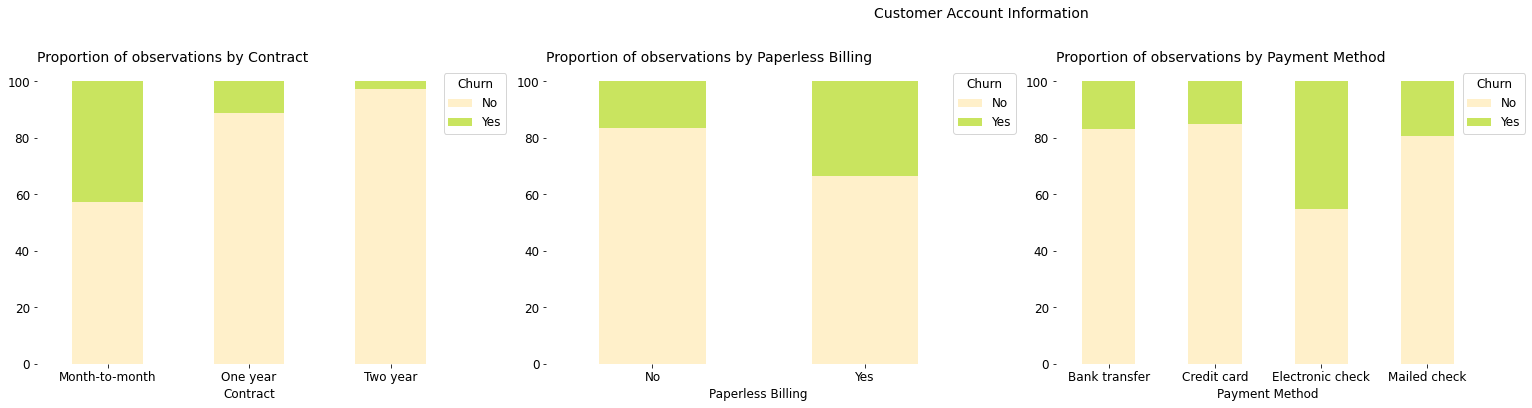

In [ ]:
acc_cols = ['Contract', 'Paperless Billing', 'Payment Method']

stacked_bar(acc_cols, 'Customer Account Information')

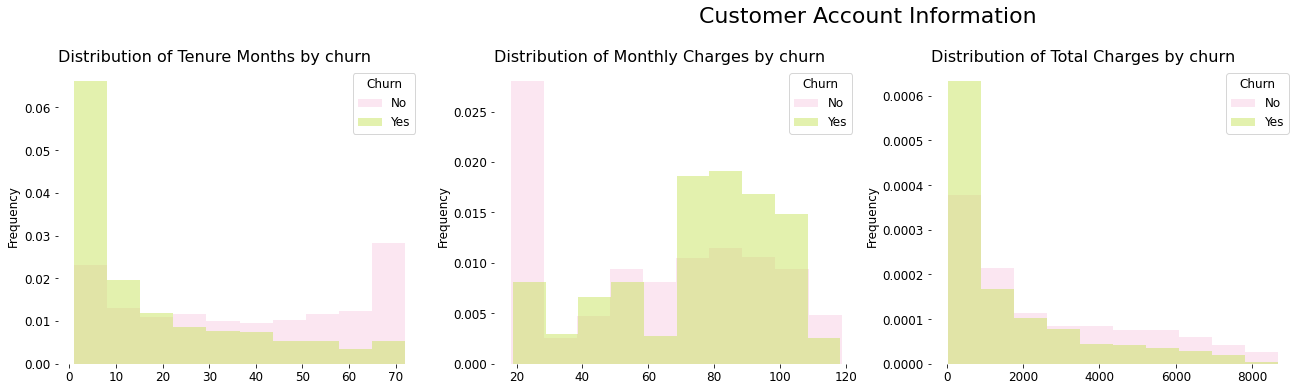

In [ ]:
acc_cols_numeric = ['Tenure Months', 'Monthly Charges', 'Total Charges']
plot_histogram(acc_cols_numeric, 'Customer Account Information')

### Services Information

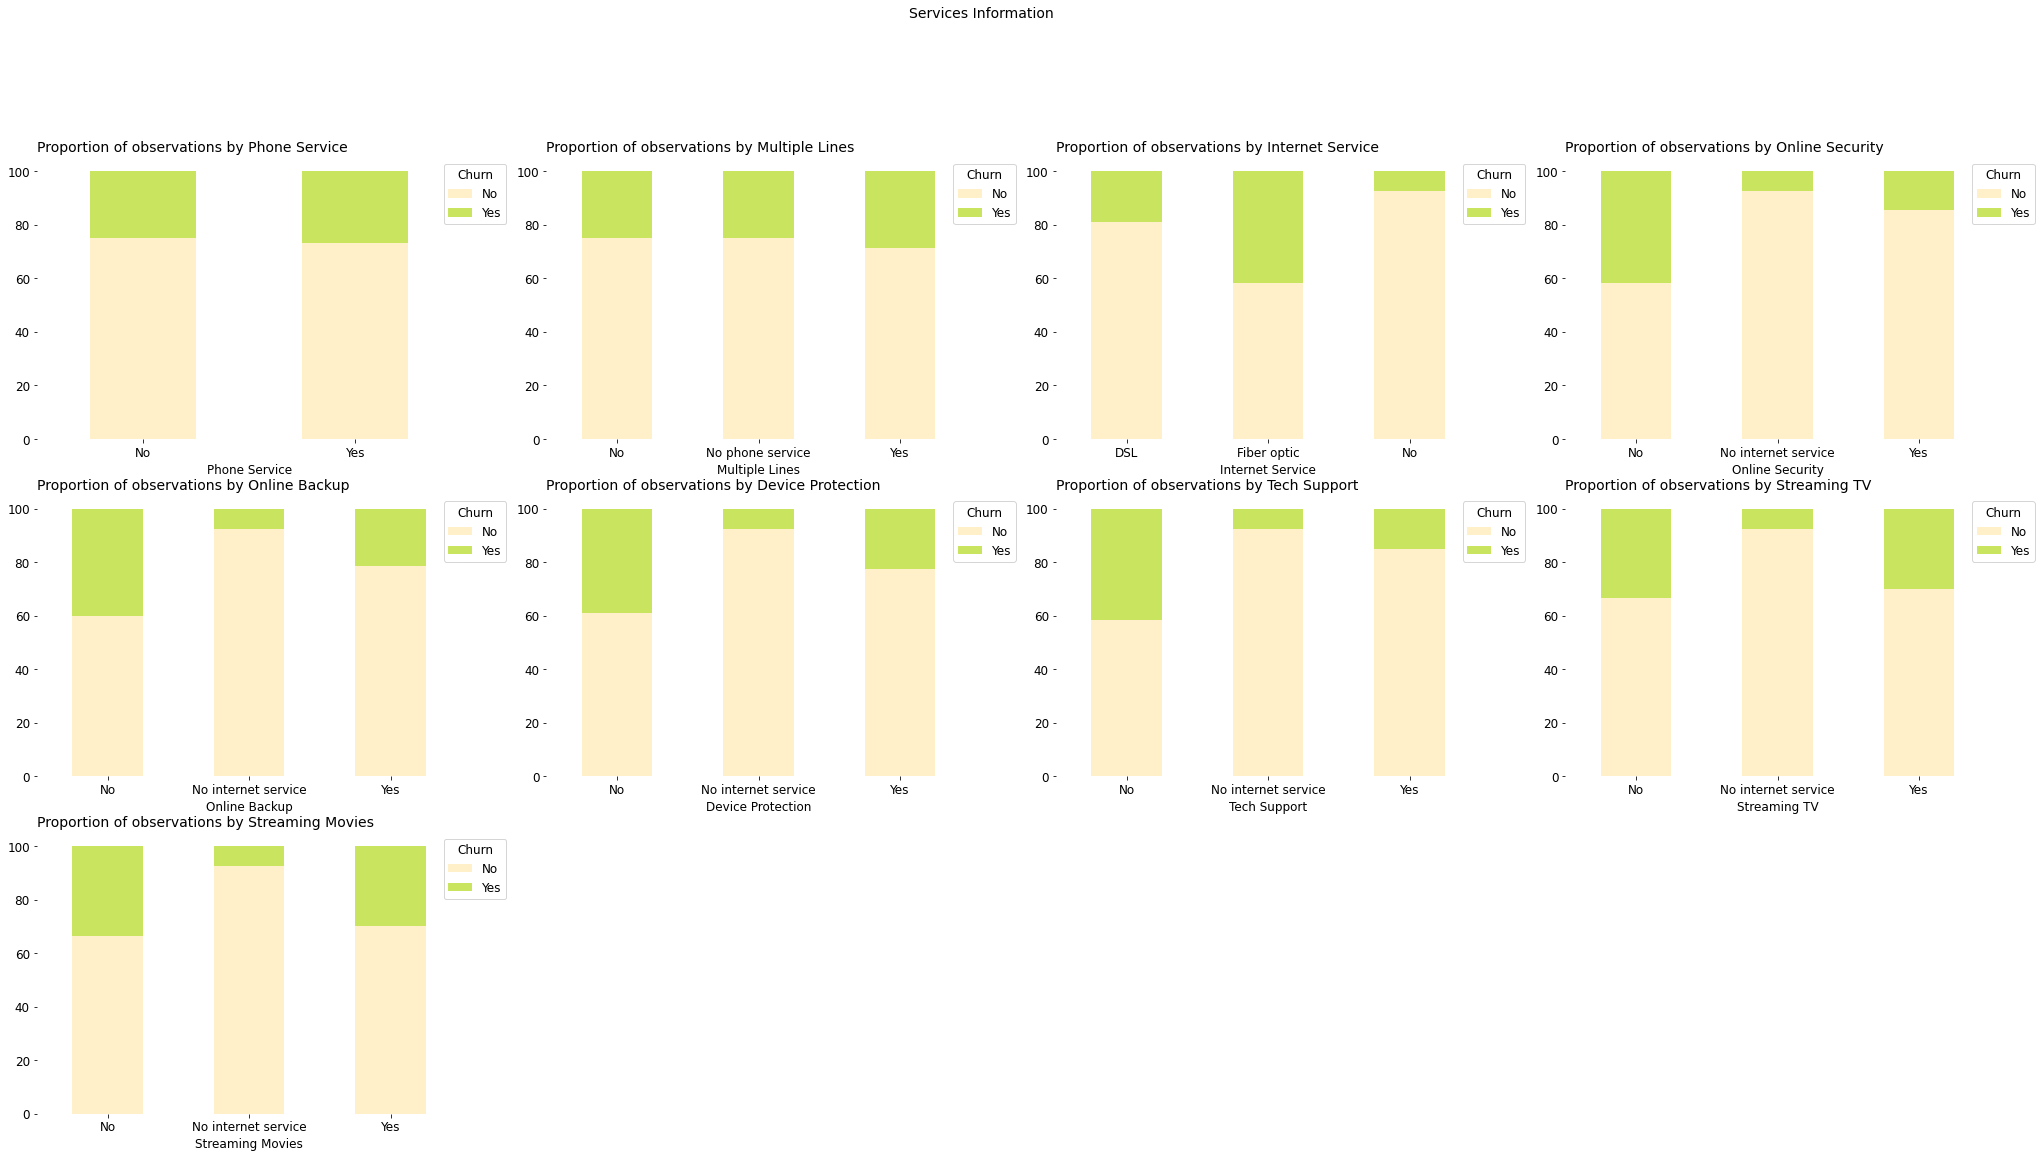

In [ ]:
services_columns = ['Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']
stacked_bar(services_columns, 'Services Information')

## Data Transformation & Feature Selection

* Assigning numerical values to categorical variables.
* One-hot encoding
* Normalization

Label encoding

In [ ]:
df_trans = df.copy()

label_encoding_columns = ['Senior Citizen', 'Partner', 'Dependents', 'Paperless Billing', 'Phone Service', 'Churn Label']

for column in label_encoding_columns:
    if column == 'Gender':
        df_trans[column] = df_trans[column].map({'Female': 1, 'Male': 0})
    else:
        df_trans[column] = df_trans[column].map({'Yes': 1, 'No': 0})

In [ ]:
df_trans = df_trans.drop(['Lat Long','City', 'Gender', 'Multiple Lines', 'Phone Service', 'Latitude', 'Longitude','Phone Service', 'Churn Value', 'Churn Score', 'CLTV'], axis = 1)

In [ ]:
df_trans.head()

,Zip Code,Senior Citizen,Partner,Dependents,Tenure Months,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label
0,90003,0,0,0,2,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
1,90005,0,0,1,2,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1
2,90006,0,0,1,8,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,99.65,820.50,1
3,90010,0,1,1,28,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,1,Electronic check,104.80,3046.05,1
4,90015,0,0,1,49,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,1,Bank transfer,103.70,5036.30,1


In [ ]:
df_trans.columns

Index(['Zip Code', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Total Charges', 'Churn Label'],
      dtype='object')

One-hot encoding

In [ ]:
one_hot_encoding_columns = ['Internet Service', 'Online Security', 'Online Backup',
                            'Device Protection', 'Tech Support', 'Streaming TV',  'Streaming Movies', 'Contract', 'Payment Method']

# encode categorical variables with more than two levels using one-hot encoding
df_trans = pd.get_dummies(df_trans, columns = one_hot_encoding_columns)

,Zip Code,Senior Citizen,Partner,Dependents,Tenure Months,Paperless Billing,Monthly Charges,Total Charges,Churn Label,Internet Service_DSL,...,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer,Payment Method_Credit card,Payment Method_Electronic check,Payment Method_Mailed check
0,90003,0,0,0,2,1,53.85,108.15,1,1,...,1,0,0,1,0,0,0,0,0,1
1,90005,0,0,1,2,1,70.70,151.65,1,0,...,1,0,0,1,0,0,0,0,1,0
2,90006,0,0,1,8,1,99.65,820.50,1,0,...,0,0,1,1,0,0,0,0,1,0
3,90010,0,1,1,28,1,104.80,3046.05,1,0,...,0,0,1,1,0,0,0,0,1,0
4,90015,0,0,1,49,1,103.70,5036.30,1,0,...,0,0,1,1,0,0,1,0,0,0


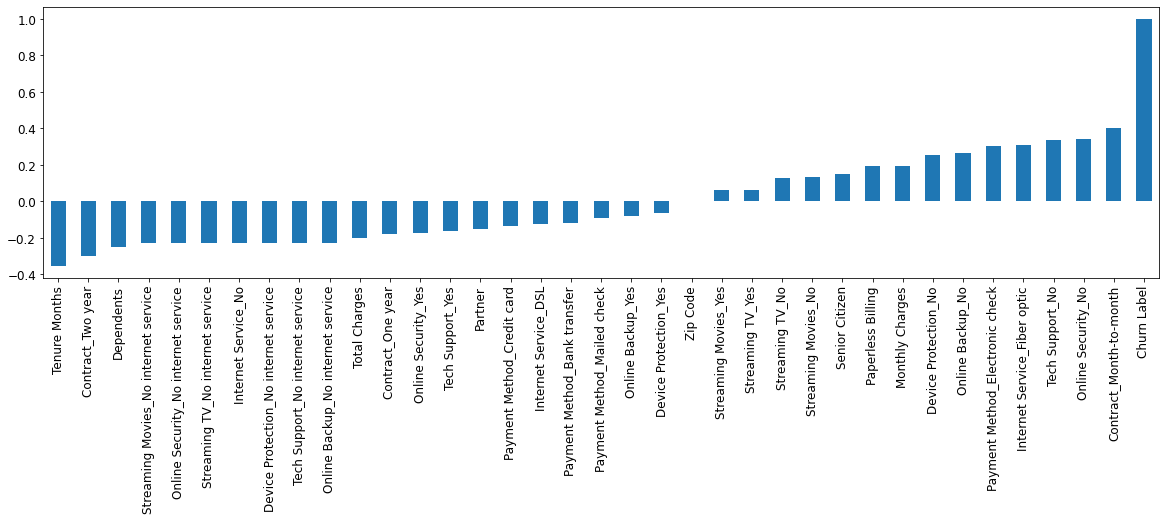

In [ ]:
df_trans.corr()['Churn Label'].sort_values(ascending = True).plot(kind = 'bar', figsize = (20,5))

Normalization

In [ ]:
cols = ['Tenure Months', 'Monthly Charges', 'Total Charges']

for column in cols:
        minc = df_trans[column].min()
        maxc = df_trans[column].max()

        df_trans[column] = (df_trans[column] - minc) / (maxc - minc)

Feature Selection

In [ ]:
X = df_trans.drop(['Churn Label'], axis = 1)
y = df_trans['Churn Label']

In [ ]:
sel =  SelectFpr(chi2, alpha=0.01)
sel.fit(X, y)
X_new = sel.transform(X)

features = pd.DataFrame({'columns': X.columns, 'Kept': sel.get_support()})

X_fpr = X.iloc[:,sel.get_support()]

In [ ]:
sel =  SelectKBest(f_classif, k=20)
sel.fit(X, y)
X_new = sel.transform(X)

features = pd.DataFrame({'columns': X.columns, 'Kept': sel.get_support()})

X_fc = X.iloc[:,sel.get_support()]

In [ ]:
sel =  SelectKBest(chi2, k=20)
sel.fit(X, y)
X_new = sel.transform(X)

features = pd.DataFrame({'columns': X.columns, 'Kept': sel.get_support()})

X_chi2 = X.iloc[:,sel.get_support()]

In [ ]:
sel =  SelectKBest(f_regression, k=20)
sel.fit(X, y)
X_new = sel.transform(X)

features = pd.DataFrame({'columns': X.columns, 'Kept': sel.get_support()})

X_fr = X.iloc[:,sel.get_support()]

## Addressing class imbalance

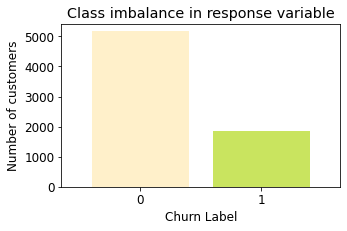

In [ ]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)

r = df_trans['Churn Label'].value_counts()

r.plot(kind = 'bar', ax = ax, color=['#FFF0CA','#C9E45F'], width = 0.8)

ax.set_title('Class imbalance in response variable')
ax.set_xlabel('Churn Label')
ax.set_ylabel('Number of customers')
ax.tick_params(rotation='auto')

### Undersampling

In [ ]:
def undersample(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  rus = RandomUnderSampler(random_state=0)
  X_under, y_under = rus.fit_resample(X_train, y_train)

  return [X_under, X_test, y_under, y_test]

### Oversampling

In [ ]:
def oversample(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.30, random_state=0)

  sm = SMOTE(random_state=42)
  X_over, y_over = sm.fit_resample(X_train, y_train)

  return [X_train, X_test, y_train, y_test]

## K-Nearest Neighbours

In [ ]:
def execute_knn(x_col, x_test, y_col, y_t):
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(x_col, y_col)

  y_pred = knn.predict(x_test)
  print("Accuracy:",accuracy_score(y_t,y_pred))
  print("\nClassification Report:\n")
  print(classification_report(y_t,y_pred))


In [ ]:
def knn_all(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("\nK-Nearest Neighbours - without any sampling:")
  execute_knn(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = undersample(X,y)
  print("\nK-Nearest Neighbours - Undersampling:")
  execute_knn(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = oversample(X,y)
  print("\nK-Nearest Neighbours - Oversampling:")
  execute_knn(X_train, X_test, y_train, y_test)

In [ ]:
# No sampling Data
knn_all(X,y)


K-Nearest Neighbours - without any sampling:
Accuracy: 0.7109004739336493

Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1557
           1       0.43      0.32      0.37       553

    accuracy                           0.71      2110
   macro avg       0.61      0.59      0.59      2110
weighted avg       0.69      0.71      0.70      2110


K-Nearest Neighbours - Undersampling:
Accuracy: 0.5289099526066351

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.48      0.60      1557
           1       0.31      0.66      0.42       553

    accuracy                           0.53      2110
   macro avg       0.55      0.57      0.51      2110
weighted avg       0.67      0.53      0.56      2110


K-Nearest Neighbours - Oversampling:
Accuracy: 0.7165913492575855

Classification Report:

              precision    recall  f1-score   support

      

In [ ]:
# Chi2 Feature Selection Data
knn_all(X_chi2,y)


K-Nearest Neighbours - without any sampling:
Accuracy: 0.7687203791469195

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1557
           1       0.57      0.50      0.53       553

    accuracy                           0.77      2110
   macro avg       0.70      0.68      0.69      2110
weighted avg       0.76      0.77      0.76      2110


K-Nearest Neighbours - Undersampling:
Accuracy: 0.7127962085308057

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1557
           1       0.47      0.74      0.57       553

    accuracy                           0.71      2110
   macro avg       0.68      0.72      0.68      2110
weighted avg       0.78      0.71      0.73      2110


K-Nearest Neighbours - Oversampling:
Accuracy: 0.7856681730148483

Classification Report:

              precision    recall  f1-score   support

      

In [ ]:
# ANOVA Feature Selection Data
knn_all(X_fc,y)


K-Nearest Neighbours - without any sampling:
Accuracy: 0.7597156398104266

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1557
           1       0.55      0.48      0.51       553

    accuracy                           0.76      2110
   macro avg       0.69      0.67      0.68      2110
weighted avg       0.75      0.76      0.75      2110


K-Nearest Neighbours - Undersampling:
Accuracy: 0.7090047393364929

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1557
           1       0.46      0.73      0.57       553

    accuracy                           0.71      2110
   macro avg       0.67      0.72      0.67      2110
weighted avg       0.77      0.71      0.72      2110


K-Nearest Neighbours - Oversampling:
Accuracy: 0.7995480955455132

Classification Report:

              precision    recall  f1-score   support

      

In [ ]:
# SelectFPR (False Positive Rate) Feature Selection Data
knn_all(X_fpr,y)


K-Nearest Neighbours - without any sampling:
Accuracy: 0.7696682464454976

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1557
           1       0.56      0.54      0.55       553

    accuracy                           0.77      2110
   macro avg       0.70      0.70      0.70      2110
weighted avg       0.77      0.77      0.77      2110


K-Nearest Neighbours - Undersampling:
Accuracy: 0.7018957345971564

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.67      0.77      1557
           1       0.46      0.80      0.58       553

    accuracy                           0.70      2110
   macro avg       0.68      0.73      0.68      2110
weighted avg       0.79      0.70      0.72      2110


K-Nearest Neighbours - Oversampling:
Accuracy: 0.8111684958037444

Classification Report:

              precision    recall  f1-score   support

      

## Decision Tree

In [ ]:
def execute_dt(x_col, x_test, y_col, y_test):
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(x_col, y_col)

  y_pred = clf.predict(x_test)

  print("Accuracy:",accuracy_score(y_test,y_pred))
  print("\nClassification Report:\n")
  print(classification_report(y_test,y_pred))

In [ ]:
def dt_all(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("\nDecision Tree - without any sampling:")
  execute_dt(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = undersample(X,y)
  print("\nDecision Tree - Undersampling:")
  execute_dt(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = oversample(X,y)
  print("\nDecision Tree - Oversampling:")
  execute_dt(X_train, X_test, y_train, y_test)

In [ ]:
# SelectFPR (False Positive Rate) Feature Selection Data
dt_all(X_fpr,y)


Decision Tree - without any sampling:
Accuracy: 0.7331753554502369

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1557
           1       0.49      0.47      0.48       553

    accuracy                           0.73      2110
   macro avg       0.65      0.65      0.65      2110
weighted avg       0.73      0.73      0.73      2110


Decision Tree - Undersampling:
Accuracy: 0.6872037914691943

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.69      0.77      1557
           1       0.44      0.67      0.53       553

    accuracy                           0.69      2110
   macro avg       0.65      0.68      0.65      2110
weighted avg       0.75      0.69      0.70      2110


Decision Tree - Oversampling:
Accuracy: 0.7750161394448031

Classification Report:

              precision    recall  f1-score   support

           0       0.77    

In [ ]:
# ANOVA Feature Selection Data
dt_all(X_fc,y)


Decision Tree - without any sampling:
Accuracy: 0.7184834123222749

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1557
           1       0.46      0.48      0.47       553

    accuracy                           0.72      2110
   macro avg       0.64      0.64      0.64      2110
weighted avg       0.72      0.72      0.72      2110


Decision Tree - Undersampling:
Accuracy: 0.70521327014218

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.71      0.78      1557
           1       0.46      0.69      0.55       553

    accuracy                           0.71      2110
   macro avg       0.66      0.70      0.67      2110
weighted avg       0.76      0.71      0.72      2110


Decision Tree - Oversampling:
Accuracy: 0.7591994835377663

Classification Report:

              precision    recall  f1-score   support

           0       0.75      

In [ ]:
# Chi2 Feature Selection Data
dt_all(X_chi2,y)


Decision Tree - without any sampling:
Accuracy: 0.7445497630331753

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1557
           1       0.51      0.48      0.50       553

    accuracy                           0.74      2110
   macro avg       0.67      0.66      0.66      2110
weighted avg       0.74      0.74      0.74      2110


Decision Tree - Undersampling:
Accuracy: 0.6938388625592417

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1557
           1       0.44      0.68      0.54       553

    accuracy                           0.69      2110
   macro avg       0.65      0.69      0.65      2110
weighted avg       0.75      0.69      0.71      2110


Decision Tree - Oversampling:
Accuracy: 0.7795351839896708

Classification Report:

              precision    recall  f1-score   support

           0       0.78    

In [ ]:
# No sampling Data
dt_all(X,y)


Decision Tree - without any sampling:
Accuracy: 0.7274881516587678

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1557
           1       0.48      0.52      0.50       553

    accuracy                           0.73      2110
   macro avg       0.65      0.66      0.66      2110
weighted avg       0.73      0.73      0.73      2110


Decision Tree - Undersampling:
Accuracy: 0.6909952606635071

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.69      0.77      1557
           1       0.44      0.69      0.54       553

    accuracy                           0.69      2110
   macro avg       0.65      0.69      0.65      2110
weighted avg       0.75      0.69      0.71      2110


Decision Tree - Oversampling:
Accuracy: 0.8121368624919303

Classification Report:

              precision    recall  f1-score   support

           0       0.81    

## Support Vector Machine

In [ ]:
from sklearn import svm

def execute_svm(x_col, x_test, y_col, y_test):
  model = svm.SVC(kernel='poly', degree=2)
  model.fit(x_col, y_col)

  y_pred = model.predict(x_test)

  print("Accuracy:",accuracy_score(y_test,y_pred))
  print("Classification Report:\n")
  print(classification_report(y_test,y_pred))


In [ ]:
def svm_all(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("\nSVM - without any sampling:")
  execute_svm(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = undersample(X,y)
  print("\nSVM - Undersampling:")
  execute_svm(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = oversample(X,y)
  print("\nSVM - Oversampling:")
  execute_svm(X_train, X_test, y_train, y_test)

In [ ]:
# No sampling Data
svm_all(X,y)


SVM - without any sampling:
Accuracy: 0.737914691943128
Classification Report:

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1557
           1       0.00      0.00      0.00       553

    accuracy                           0.74      2110
   macro avg       0.37      0.50      0.42      2110
weighted avg       0.54      0.74      0.63      2110


SVM - Undersampling:
Accuracy: 0.556872037914692
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.59      0.66      1557
           1       0.29      0.46      0.35       553

    accuracy                           0.56      2110
   macro avg       0.52      0.53      0.51      2110
weighted avg       0.63      0.56      0.58      2110


SVM - Oversampling:
Accuracy: 0.49128469980632666
Classification Report:

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1522
       

In [ ]:
# ANOVA Feature Selection Data
svm_all(X_fc,y)


SVM - without any sampling:
Accuracy: 0.7848341232227488
Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1557
           1       0.61      0.49      0.54       553

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.78      2110


SVM - Undersampling:
Accuracy: 0.7459715639810427
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1557
           1       0.51      0.77      0.61       553

    accuracy                           0.75      2110
   macro avg       0.71      0.75      0.71      2110
weighted avg       0.80      0.75      0.76      2110


SVM - Oversampling:
Accuracy: 0.7650096836668818
Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1522
      

In [ ]:
# Chi2 Feature Selection Data
svm_all(X_chi2,y)


SVM - without any sampling:
Accuracy: 0.785781990521327
Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1557
           1       0.62      0.46      0.53       553

    accuracy                           0.79      2110
   macro avg       0.72      0.68      0.70      2110
weighted avg       0.77      0.79      0.77      2110


SVM - Undersampling:
Accuracy: 0.7502369668246446
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1557
           1       0.52      0.77      0.62       553

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.76      2110


SVM - Oversampling:
Accuracy: 0.7679147837314396
Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1522
       

In [ ]:
# SelectFPR (False Positive Rate) Feature Selection Data
svm_all(X_fpr,y)


SVM - without any sampling:
Accuracy: 0.7909952606635071
Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1557
           1       0.63      0.50      0.55       553

    accuracy                           0.79      2110
   macro avg       0.73      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110


SVM - Undersampling:
Accuracy: 0.7369668246445498
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1557
           1       0.50      0.80      0.62       553

    accuracy                           0.74      2110
   macro avg       0.70      0.76      0.71      2110
weighted avg       0.80      0.74      0.75      2110


SVM - Oversampling:
Accuracy: 0.8218205293737896
Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1522
      

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB

def execute_nb(x_col, x_test, y_col, y_test):
  model = MultinomialNB()
  model.fit(x_col, y_col)

  y_pred = model.predict(x_test)

  print("Accuracy:",(accuracy_score(y_test,y_pred)))

  print("\nClassification Report:\n")
  print(classification_report(y_test,y_pred))

In [ ]:
def nb_all(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("\nNB - without any sampling:")
  execute_nb(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = undersample(X,y)
  print("\nNB - Undersampling:")
  execute_nb(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = oversample(X,y)
  print("\nNB - Oversampling:")
  execute_nb(X_train, X_test, y_train, y_test)


In [ ]:
# No sampling Data
nb_all(X,y)


NB - without any sampling:
Accuracy: 0.714218009478673

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1557
           1       0.47      0.80      0.59       553

    accuracy                           0.71      2110
   macro avg       0.69      0.74      0.69      2110
weighted avg       0.79      0.71      0.73      2110


NB - Undersampling:
Accuracy: 0.6862559241706161

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      1557
           1       0.45      0.84      0.59       553

    accuracy                           0.69      2110
   macro avg       0.68      0.74      0.67      2110
weighted avg       0.80      0.69      0.71      2110


NB - Oversampling:
Accuracy: 0.8192382182052937

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1522
       

In [ ]:
# Chi2 Feature Selection Data
nb_all(X_chi2,y)


NB - without any sampling:
Accuracy: 0.7132701421800948

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1557
           1       0.47      0.81      0.60       553

    accuracy                           0.71      2110
   macro avg       0.69      0.74      0.69      2110
weighted avg       0.79      0.71      0.73      2110


NB - Undersampling:
Accuracy: 0.6767772511848341

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.61      0.74      1557
           1       0.44      0.86      0.58       553

    accuracy                           0.68      2110
   macro avg       0.68      0.73      0.66      2110
weighted avg       0.80      0.68      0.70      2110


NB - Oversampling:
Accuracy: 0.7475790832795352

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.62      0.71      1522
      

In [ ]:
# ANOVA Feature Selection Data
nb_all(X_fc,y)


NB - without any sampling:
Accuracy: 0.681042654028436

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1557
           1       0.44      0.86      0.59       553

    accuracy                           0.68      2110
   macro avg       0.68      0.74      0.66      2110
weighted avg       0.80      0.68      0.70      2110


NB - Undersampling:
Accuracy: 0.6265402843601896

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.53      0.68      1557
           1       0.40      0.90      0.56       553

    accuracy                           0.63      2110
   macro avg       0.67      0.71      0.62      2110
weighted avg       0.80      0.63      0.65      2110


NB - Oversampling:
Accuracy: 0.7227243382827631

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.54      0.66      1522
       

In [ ]:
# SelectFPR (False Positive Rate) Feature Selection Data
nb_all(X_fpr,y)


NB - without any sampling:
Accuracy: 0.7137440758293839

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1557
           1       0.47      0.80      0.59       553

    accuracy                           0.71      2110
   macro avg       0.69      0.74      0.69      2110
weighted avg       0.79      0.71      0.73      2110


NB - Undersampling:
Accuracy: 0.6867298578199053

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      1557
           1       0.45      0.84      0.59       553

    accuracy                           0.69      2110
   macro avg       0.68      0.74      0.67      2110
weighted avg       0.80      0.69      0.71      2110


NB - Oversampling:
Accuracy: 0.7653324725629438

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.66      0.73      1522
      